In [783]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', None) # Настройка Pandas для отображения всех столбцов при выводе данных.

data = pd.read_csv('main_task.csv')

1. **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
2. **City** — город, в котором находится ресторан;
3. **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
4. **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
5. **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
6. **Price Range** — диапазон цен в ресторане;
7. **Number of Reviews** — количество отзывов о ресторане;
8. **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
9. **URL_TA** — URL страницы ресторана на TripAdvisor;
10. **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.

In [784]:
data.rename(columns={'Restaurant_id': 'Restaurant_id',
                    'City': 'city',
                    'Cuisine Style': 'cuisine_style',
                    'Ranking': 'ranking',
                    'Rating': 'Rating',
                    'Price Range':'price_range',
                    'Number of Reviews':'number_of_reviews',
                    'Reviews':'reviews',
                    'URL_TA':'url_ta',
                    'ID_TA':'id_ta'}, inplace=True)

### Столбец cuisine_style (кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане)
Кухни предлагаемые в ресторане фактически составляют список, но в датасете он представлен как строка содержащая синтаксические элементы списка. Приведем значения в этом столбце к типу список.

In [785]:
def str_list(x):
    """Функция переводит строковое значение перечня кухонь
    в список, в котором каждая кухня - отдельная строка.
    Применяется к столбцу cuisine_style, принимает и обрабатывает 
    поочередно каждую запись в этом столбце"""
    if pd.notnull(x):
        x = x.lower()     # В нижний регистр для удобства дальнейшей обработки.
        x = x[1:-1]       # Убираем символы кавычек в начале и конце строки.
        x = x.split(', ') # Разделяем кухни на отдельные строки в списке.
        for y in range(len(x)):    # Пробегая по списку, удаляем символы кавычек
            x[y] = x[y].strip("'") # из каждой кухни-строки.
        return x        

In [786]:
data['cuisine_style'] = data['cuisine_style'].apply(str_list)
# Переводим строки в данном столбце в список кухонь.

### Столбец price_range (диапазон цен в ресторане)
Этот признак уровень цен в ресторане, и является категориальной парядковой переменной. В датасете этот признак принимает всего 3 значения.

Избавимся от символьных значений и приведем числовые категории к числовому виду в соответствии со словарем.

In [787]:
data = data.replace({'price_range':{'$':1, '$$ - $$$':2, '$$$$':3}})
# Присваиваем диапазонам цен значения от 1 до 3.

### Столбец reviews (отзывы на странице ресторана)
Отзывы о ресторане фактически составляют список, но в датасете он представлен как строка содержащая синтаксические элементы списка. Приведем значения в этом столбце к типу список.

В данном столбце так же содержатся даты отзывов, выделим их в отдельный столбец и приведем к типу DateTime.

In [788]:
data.reviews[0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [789]:
def reviews_list(x):
    '''Функция для обработки столбца reviews. Принимает и обрабатывает каждую
        запись в столбце. Переводит единую строку с отзывами и датами в список
        отзывов и список дат.'''
    if pd.notnull(x): # В столбце имеются пропуски, которые не обработать функцией.
            x = x.lower() # К нижнему регистру для удобства дальнейшей обработки.
            x = x[2:-2]   # Удаляем двойные квадратные скобки вначале и вконце строки.
            x = x.split('], [') # Разделяем строку и переводим в список: отзывы, даты.
            for y in range(len(x)):       # В каждой строке из полученного списка:
                x[y] = x[y].strip("'")    # 1. убираем символы ковычек в начале и конце
                x[y] = x[y].split("', '") # 2. разделяем строки отзывов и дат на список отзывов и дат.
            if len(x[0]) == 1:     # Некоторые списки отзывов и дат содержат один элемент.
                x[0].insert(1, '') # Добавляем второй элемент для одинакового формата всех записей.
            if len(x[1]) == 1:
                x[1].insert(1, '')
            return x
    else:
        return [['', ''], ['', '']] # Вместо пропусков вставляем списки пустых строк.   

In [790]:
data['reviews_list'] = data['reviews'].apply(reviews_list)

Распределим отзывы и даты каждый в свой столбец. По содержанию столбца отзывов видно, что более поздняя дата стоит впереди, видимо и более поздний отзыв стоит впереди. Исходя из этого соображения распределим значения.

In [791]:
data['review_2'] = data['reviews_list'].apply(lambda x: x[0][0])
data['date_2'] = data['reviews_list'].apply(lambda x: x[1][0])
data['review_1'] = data['reviews_list'].apply(lambda x: x[0][1])
data['date_1'] = data['reviews_list'].apply(lambda x: x[1][1])

In [792]:
display(data.review_2.isnull().sum(),
       data.date_2.isnull().sum(),
       data.review_1.isnull().sum(),
       data.date_1.isnull().sum())

0

0

0

0

Столбец отзывов со списком удаляем, он больше не понадобится.

In [793]:
data.drop(columns = 'reviews_list', inplace = True)

### Работа со столбцами date_1 и date_2
После выделения этих столбцов из отзывов они имеют строковый тип. Для того, чтобы из них можно было получить полезную информацию, приведем их к типу datetime.

In [794]:
data['date_1']= pd.to_datetime(data['date_1'])
data['date_2']= pd.to_datetime(data['date_2'])

### Обработка столбца id_ta
Это уникальный номер ресторана на сайте ТА. В датасете он имеет строковый тип так как впереди стоит буква d. Удалим эту букву и приведем id к числовому типу.

In [795]:
data['id_ta'] = data['id_ta'].apply(lambda x: str(x)[1:])
# Берем срез для исключения букв.

data['id_ta'] = pd.to_numeric(data['id_ta'])
# Переводим строковое значение в числовое, получаем int64.

### Извлечение названия ресторана из адреса страницы ресторана на сайте ТА. (url_ta)
Можно выделить название ресторана для для определения сети ресторанов. URL каждого ресторана имеет четкую одинаковую для всех структуру. Используя это выделяем название ресторана. Приведем все названия к нижнему регистру для исключения различий ресторанов из-за разного написания.    

In [796]:
data.url_ta[0]

'/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html'

In [797]:
def name_rest(row):
        '''Функция принимает строку датасета. Используя имя города
        из data['city'] разделяет строку url и выбирает часть 
        содержащую название ресторана. Возвращает название рестрана.'''
        name = row['url_ta'].partition( 'Reviews-')[2]
        # Разделяем строку адреса по разделителю 'Reviews-'.
        # берем третью часть содержащую название ресторана.
        name = name.partition('-' + row['city'])[0]
        # Строку с названием разделяем по '_город',
        # берем первую часть - собственно название ресторана.
        name = name.lower() 
        # Для исключения несовпадений из-за разного написания названия.
        return name

In [798]:
data['name_rest'] = data.apply(name_rest, axis = 1)
# Создаем новый столбец при помощи ранее написанную функцию.

Часто к названию ресторанов принадлежащих крупным сетям добавляют название города или МЕГА и тому подобное. Чтобы эти сетевые рестораны не значились как самостоятельные приведем их название к общему сетевому для таких сетей как:
1. mcdonald_s
2. burger_king
3. subway
4. pret_a_manger
5. kfc

Вручную составим список.

In [799]:
name_rest_list = ['mcdonald_s','burger_king','subway','pret_a_manger','kfc']

In [800]:
def name_correct(x):
        '''Функция проверяет, содержится ли в длинном
        названии рестрана стандартное название сетевого 
        рестрана, и если содержится, то сокращает его 
        до стандартного.'''
        for name in name_rest_list:
            if name in x:
                x = name
        return x

In [801]:
data['name_rest'] = data['name_rest'].apply(name_correct)

## Заполнение пропусков

### Столбец Cuisine Style

In [802]:
data.cuisine_style.isnull().sum()

9283

Предварительно создаем столбец содержащий информацию о том, где были пропуски до заполнения.

In [803]:
data['cuisine_style_isnan'] = pd.isna(data['cuisine_style']).astype('uint8')

#### Создание списка кухонь, которые встречаются во всех ресторанах - cuisin_list.

In [804]:
cuisin_list = list(data[pd.notnull(data.cuisine_style)]
                   .explode('cuisine_style').cuisine_style.unique())

В списке кухонь все кухни со строчной буквы, а в отзывах названия кухонь могут начинаться с заглавной. Значения в столбце reviews приведем к нижнему регистру для исключения несовпадений при поиске кухни в отзыве из-за разных регистров букв.

In [805]:
data['reviews'] = data['reviews'].apply(lambda x: x.lower() if pd.notnull(x) else x)

In [806]:
data.reviews.fillna('', inplace = True) 
# Чтобы не мешали итерации по строкам NaN заменим пустой строкой

#### Создание списока всех слов встречающихся в отзывах - word_list

In [807]:
reviews_list = list(data['review_1']) + list(data['review_2'])
# Сначала составим список всех отзывов из двух столбцов.


word_set = set() # Пустое множество для отбора уникальных слов.
for review in reviews_list:
    for word in review.split(' '): # Разделяем строки на слова.
        word_set.add(word) # Добавляем слова в множество.        
        
        
word_list = list(sorted(word_set))
# Сортируем и переводим в список для удобства использования.

Если бегло просмотреть получившийся список слов, то часто можно увидеть названия кухонь.

In [808]:
def name_rest_cuisine(row):
        '''Функция пробегает по списку кухонь проверяет, есть ли 
        упоминание кухни в отзыве о ресторане. Если встречается 
        упоминание кухни, то ее название добавляется в список 
        кухонь ресторана.'''
        if row['cuisine_style'] is None:
            cuisine_rest = []
            for cuisine in cuisin_list:
                if cuisine in row['name_rest']:
                    cuisine_rest.append(cuisine)
                if cuisine in row['reviews']:
                    cuisine_rest.append(cuisine)
            if len(cuisine_rest) > 0:
                return  list(set(cuisine_rest))
            else:
                return row['cuisine_style']
        else:
            return row['cuisine_style']    

In [809]:
data['cuisine_style'] = data.apply(name_rest_cuisine, axis = 1)

In [810]:
data.cuisine_style.isnull().sum()

6383

Количество пропусков уменшилось почти на 3 тысячи.

In [811]:
rest_list = list(set(data.name_rest))
# Создаем список ресторанов для далнейших итераций по нему
len(rest_list)

37359

Количество названий ресторанов гораздо меньше, чем записей в датасете, так как многие рестораны сетевые и имеют несколько точек под одним брендом. Такие бренды имеют одинаковую кухню, и иногда добавляют кухню страны, в которой находится. Это можно использовать для заполнения пропусков  в столбце cuisine_style.



Сначала составим список сетевых ресторанов, внесем в него те рестораны, которые имеют не меньше 3 локаций с одним незванием. Такое количество исключит случайное совпадение названий с большой вероятностью.

In [812]:
rest = data.name_rest.value_counts() # Создаем серию: ресторан - количество.
rest_list_modif = list(set(rest[rest >= 3].index))
# Фильтруем серию по количеству и переводим в список.

На основе списка ресторанов собираем словарь, который будет содержать в качестве ключа название ресторана, а значение - две наиболее часто встречающиеся в этой сети ресторанов кухни.

In [813]:
rest_cuisine_dict = {}
for rest in rest_list_modif:
    rest_cuisine_dict[rest] = list(data[data.name_rest == rest]. #Фильтруем по городу
                               explode('cuisine_style'). #Разбиваем списки на кухни 
                               cuisine_style.value_counts(). #Группируем и считаем кухни
                               index)[:2] #Берем три самые частые кухни

In [814]:
def rest_cuisine(row):
    """Функция заполняет пропуски кухонь наиболее типичными 
    кухнями для сетевых ресторанов, если пропуск кухни встречается
    у сетевого ресторана."""
    if row['cuisine_style'] is None:
        if row['name_rest'] in rest_list_modif:
            return rest_cuisine_dict[row['name_rest']]
        else:
            return row['cuisine_style']
    else:
        return row['cuisine_style']  

In [815]:
data['cuisine_style'] = data.apply(rest_cuisine, axis = 1)

In [816]:
data.cuisine_style.isnull().sum()

5953

Оставшиеся пропуски заполним в разрезе города, в котором находится ресторан. Заполнять пропуски будем списками из трех самых часто встречающихся в городе кухонь.

Сначала соберем **словарь содержащий самые частые кухни для каждого города. Для словаря список городов**.

In [817]:
city_list = list(set(data.city))

In [818]:
city_cuisine_count = {}
for city in city_list:
    city_cuisine_count[city] = list(data[data.city == city]. #Фильтруем по городу
                               explode('cuisine_style'). #Разбиваем списки на кухни 
                               cuisine_style.value_counts(). #Группируем и считаем кухни
                               index)[:3] #Берем три самые частые кухни

Функция вместо пропуска ставит список кухонь из словаря.

In [819]:
def sity_cuisine(row):
    if row['cuisine_style'] is None:
        return city_cuisine_count[row['city']]
    else:
        return row['cuisine_style']        

In [820]:
data['cuisine_style'] = data.apply(sity_cuisine, axis = 1)

In [821]:
data.cuisine_style.isnull().sum()

0

### Замена редких кухонь в толбце cuisine_style
Создаем словарь содержащий частоту встречаемости каждой кухни в датасете.

In [822]:
cuisine_dict = dict(data.cuisine_style.explode('cuisine_style').value_counts())
cuisine_dict

{'vegetarian friendly': 16606,
 'european': 13800,
 'mediterranean': 8354,
 'italian': 7272,
 'gluten free options': 4672,
 'vegan options': 4496,
 'french': 4273,
 'bar': 4161,
 'spanish': 3961,
 'cafe': 3276,
 'pizza': 3162,
 'asian': 3040,
 'pub': 2620,
 'british': 2111,
 'fast food': 1966,
 'central european': 1659,
 'international': 1593,
 'seafood': 1522,
 'american': 1511,
 'japanese': 1503,
 'portuguese': 1434,
 'sushi': 1271,
 'chinese': 1208,
 'indian': 1100,
 'german': 944,
 'thai': 790,
 'middle eastern': 788,
 'czech': 780,
 'wine bar': 711,
 'greek': 710,
 'healthy': 658,
 'halal': 608,
 'grill': 596,
 'austrian': 591,
 'fusion': 591,
 'steakhouse': 579,
 'barbecue': 560,
 'polish': 550,
 'vietnamese': 529,
 'contemporary': 525,
 'soups': 500,
 'eastern european': 496,
 'turkish': 478,
 'gastropub': 471,
 'belgian': 467,
 'mexican': 463,
 'hungarian': 452,
 'delicatessen': 401,
 'dutch': 399,
 'scandinavian': 390,
 'south american': 375,
 'irish': 356,
 'lebanese': 344,
 

Некоторые кухни встречаютс очень редко, заменим слишком узкие кухни на кухни более крупного региона, в котором они находятся. Для установления соответствия вручную составим словарь.

In [823]:
change_cuisine_dict = {'burmese':'southeast asian',
                        'yunnan': 'chinese',
                        'salvadoran': 'latin',
                        'latvian': 'eastern european',
                        'xinjiang': 'chinese',
                        'azerbaijani':'middle eastern', 
                        'welsh': 'british',
                        'fujian': 'chinese',
                        'polynesian': 'southeast asian',
                        'ecuadorean': 'latin',
                        'caucasian': 'middle eastern', 
                        'native american': 'american',
                        'uzbek': 'asian',
                        'canadian': 'american',
                        'new zealand': 'international',
                        'albanian': 'mediterranean',
                        'chilean': 'latin',
                        'romanian': 'eastern european',
                        'minority chinese': 'chinese',
                        'filipino': 'southeast asian',
                        'armenian':'middle eastern',
                        'mongolian': 'asian',
                        'southwestern': 'american',
                        'georgian': 'middle eastern',
                        'ukrainian': 'eastern european',
                        'singaporean': 'southeast asian',
                        'cajun & creole': 'american',
                        'egyptian': 'arabic',
                        'colombian': 'latin',
                        'cambodian':'southeast asian',
                        'tunisian': 'arabic',
                        'hawaiian': 'american',
                        'taiwanese': 'chinese',
                        'afghani': 'asian',
                        'cuban': 'caribbean',
                        'tibetan': 'chinese',
                        'australian': 'international',
                        'sri lankan': 'south asian',
                        'jamaican': 'caribbean',
                        'croatian': 'mediterranean',
                        'malaysian': 'southeast asian',
                        'venezuelan': 'latin',
                        'ethiopian': 'african',
                        'kosher': 'israeli',
                        'persian': 'arabic',
                        'russian': 'eastern european',
                        'indonesian': 'southeast asian',
                        'slovenian': 'eastern european',
                        'bangladeshi': 'south asian',
                        'nepali': 'african',
                        'balti': 'eastern european',
                        'peruvian': 'latin',
                        'pakistani': 'south asian',
                        'brazilian': 'latin',
                        'moroccan': 'african',
                        'central american': 'central american',
                        'caribbean': 'caribbean',
                        'israeli': 'israeli',
                        'arabic': 'arabic',
                        'norwegian': 'scandinavian',
                        'central asian': 'asian',
                        'caffe': 'cafe'}

Сначала на основе словаря cuisine_dict составим список кухонь, которые встречаются чаще 150 раз.

In [824]:
cuisine_list_improv = []
for key in cuisine_dict:
    if cuisine_dict[key] > 150:
        cuisine_list_improv.append(key) 

In [825]:
def cuisine_improv(x):
    """функцию, которая будет проверять список кухонь 
    в каждом ресторане и заменять редкие кухни на кухни
    из словаря соответствия кухонь change_cuisine_dict."""
    y = []
    for cuisine in x:
        if cuisine in cuisine_list_improv:
            y.append(cuisine)
        else:
            y.append(change_cuisine_dict[cuisine])
    return y

In [826]:
data['cuisine_style'] = data['cuisine_style'].apply(cuisine_improv)

### Столбец price_range

Создадим столбец содержащий информацию о том, где были пропуски в исходном столбце.

In [827]:
data['price_range_isnan'] = pd.isna(data['price_range']).astype('uint8')

Многие рестораны в датасете сетевые, они придерживаются одинаковой ценовой политики. Составим словарь с медианным прайсом для каждого ресторана. В случае отсутствия для данного ресторана значения цены в соответствующем столбце, заполним пропуск из словаря значением для этой сети ресторанов.

In [828]:
data.price_range.isnull().sum()

13886

In [829]:
rest_price_dict = dict(data.groupby('name_rest')
                       .price_range.median().sort_values())
# Словарь с медианным прайсом для каждого ресторана.

In [830]:
def rest_price(row):
    """Функция в случае отсутствия значения в столбце 
    price_range заменяет его средним значением для 
    сети ресторанов."""
    if pd.isnull(row['price_range']):
        return round(rest_price_dict[row['name_rest']],0)
    else:
        return row['price_range']

In [831]:
data['price_range'] = data.apply(rest_price, axis = 1)

In [832]:
data.price_range.isnull().sum()

12802

Заполнилось более тысячи пропусков. Дальнейшее заполнение проведем позднее, после создания новых столбцов.

### Создание столбца ranking_normal

Так как в столбце ranking для каждого ресторана указано его уровень среди ресторанов своего города, то невозможно сравнивать Такуровень ресторанов из разных городов. Будем предполагать, что лучшие рестораны в каждом городе примерно одного уровня, и худшие тоже примерно равного уровня. Для того, чтобы можно было сравнивать рестораны из разных городов, проведем MinMax нормализацию рейтинга для каждого города.

Сначала составим словарь содержащий для каждого города норму для нормализации, она будет равна максимальное значение ranking минус 1, то есть минимальное значение. Минимум для всех будет 1, так как лучший ресторан на первом месте даже если ресторан стоящий на первом месте в датасет не попал.

In [833]:
ranking_norma_dict = {}
for city in city_list:
    ranking_norma_dict[city] = data[data['city'] == city].ranking.max() - 1

Далее проведем нормализацию.

In [834]:
data['ranking_norm'] = data.apply(lambda x:(x['ranking'] - 1) 
                                  / ranking_norma_dict[x['city']] , axis = 1)

In [835]:
data[['Rating','ranking_norm']].corr()

,Rating,ranking_norm
Rating,1.000000,-0.544589
ranking_norm,-0.544589,1.000000


<AxesSubplot:>

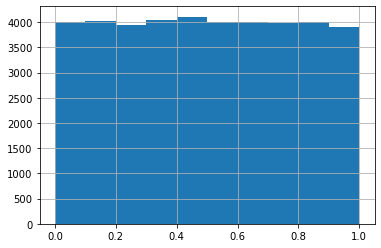

In [836]:
data.ranking_norm.hist()
# Распределение плоское.

### Создание столбца ranking_standard

При помощи нормализации мы привели рейтинги ресторанов в каждом городе к одному масштабу. Но лучший ресторан Любляны не равен по уровню лучшему ресторану Женевы. Необходимо найти критерий, по которому можно сравнить уровень ресторанов в разных городах. Таким критерием можно выбрть сеть ресторанов, в которой придерживаются одного стандарта обслуживания, набора кухонь и ценовой политики. Такими ресторанами сравнения могут стать рестораны  mcdonald_s, burger_king и subway. Если к каком то городе нет mcdonald_s, смотрим burger_king, если и его нет, смотрим  subway.

In [837]:
data.name_rest.value_counts().head(10)

mcdonald_s        135
burger_king        62
subway             62
kfc                61
pret_a_manger      53
pizza_express      36
domino_s_pizza     32
pizza_hut          25
eat                24
telepizza          20
Name: name_rest, dtype: int64

In [838]:
mcdonald_s_max = {}
for city in city_list:
    mcdonald_s_max[city] = data[(data.name_rest == 'mcdonald_s')
                                & (data.city == city)].ranking_norm.max()

In [839]:
mcdonald_s_max

{'Copenhagen': 0.9332654100866021,
 'Paris': 0.998069360028602,
 'Zurich': 0.8980490874764002,
 'Helsinki': 0.6833333333333333,
 'Hamburg': 0.9316270566727605,
 'Berlin': 0.9786532726416575,
 'Milan': 0.9835830411220912,
 'Amsterdam': 0.8913177339901478,
 'London': 0.9874110563765737,
 'Lisbon': 0.876210979547901,
 'Barcelona': 0.9550994227068633,
 'Brussels': 0.8384948384948385,
 'Ljubljana': nan,
 'Luxembourg': 1.0,
 'Warsaw': 0.7448598130841122,
 'Bratislava': 0.6283783783783784,
 'Krakow': 0.6395816572807723,
 'Rome': nan,
 'Lyon': 0.9898686679174484,
 'Oporto': 0.7147673634524613,
 'Budapest': 0.9109560935576528,
 'Prague': 0.9586816336278958,
 'Vienna': 0.9410397908800465,
 'Oslo': 0.8283450704225352,
 'Dublin': 0.9948953547728433,
 'Munich': 0.9489500362056481,
 'Madrid': 0.9879654859218892,
 'Geneva': 0.9454674220963173,
 'Athens': 0.5005599104143337,
 'Stockholm': nan,
 'Edinburgh': 0.9076487252124645}

In [840]:
burger_king_max = {}
for city in city_list:
    burger_king_max[city] = data[(data.name_rest == 'burger_king')
                                 & (data.city == city)].ranking_norm.max()

In [841]:
burger_king_max

{'Copenhagen': nan,
 'Paris': 0.9868430461208437,
 'Zurich': 0.7658904971680303,
 'Helsinki': 0.7578947368421053,
 'Hamburg': 0.9692870201096893,
 'Berlin': 0.9996860775388479,
 'Milan': nan,
 'Amsterdam': 0.5603448275862069,
 'London': 0.9694094751566016,
 'Lisbon': 0.39720129171151775,
 'Barcelona': 0.9701090442591405,
 'Brussels': nan,
 'Ljubljana': nan,
 'Luxembourg': nan,
 'Warsaw': nan,
 'Bratislava': nan,
 'Krakow': 0.5164923572003218,
 'Rome': 0.8186711522287636,
 'Lyon': 0.9891181988742964,
 'Oporto': nan,
 'Budapest': 0.969224456298728,
 'Prague': 0.910198232624791,
 'Vienna': 0.9831542259657275,
 'Oslo': 0.8908450704225352,
 'Dublin': 0.8994384890250128,
 'Munich': 0.9163649529326575,
 'Madrid': 0.9692325158946412,
 'Geneva': nan,
 'Athens': nan,
 'Stockholm': 0.9309784815265936,
 'Edinburgh': 0.975070821529745}

In [842]:
subway_max = {}
for city in city_list:
    subway_max[city] = data[(data.name_rest == 'subway')
                            & (data.city == city)].ranking_norm.max()

In [843]:
subway_max

{'Copenhagen': nan,
 'Paris': 0.9002502681444404,
 'Zurich': 0.7463813719320327,
 'Helsinki': 0.8605263157894737,
 'Hamburg': 0.9261425959780621,
 'Berlin': 0.917595353947575,
 'Milan': nan,
 'Amsterdam': nan,
 'London': 0.9766465973362525,
 'Lisbon': 0.990043057050592,
 'Barcelona': 0.8116741500962156,
 'Brussels': nan,
 'Ljubljana': 0.6745182012847966,
 'Luxembourg': nan,
 'Warsaw': nan,
 'Bratislava': 0.5146396396396397,
 'Krakow': nan,
 'Rome': nan,
 'Lyon': 0.8386491557223265,
 'Oporto': nan,
 'Budapest': 0.6934755847353303,
 'Prague': 0.5598280391688559,
 'Vienna': nan,
 'Oslo': 0.6161971830985915,
 'Dublin': 0.8861664114344053,
 'Munich': 0.8312816799420709,
 'Madrid': 0.6148955495004541,
 'Geneva': nan,
 'Athens': nan,
 'Stockholm': 0.8968737312220869,
 'Edinburgh': 0.945042492917847}

Из  трех словарей собираем один, содержащий сетевой ресторан в каждом городе. В трех городах таким рестораном будет не Макдоналдс, но ресторан такого же уровня.

In [844]:
standard_rest = {}
for city in city_list:
    if pd.notnull(mcdonald_s_max[city]):
        standard_rest[city] = mcdonald_s_max[city]
        # Сначала ищем Макдоналдс для каждого города.
    elif pd.notnull(burger_king_max[city]):
        standard_rest[city] = burger_king_max[city]
        # Далее ищем Бургер Кинг
    else:
        standard_rest[city] = subway_max[city]
        # Любляну заполним Сабвеем.

In [845]:
rest_standard = pd.Series(standard_rest).sort_values()
rest_standard
# Рестораны имеющие общий стандарт обслуживания занимают разные позиции в разных городах.

Athens        0.500560
Bratislava    0.628378
Krakow        0.639582
Ljubljana     0.674518
Helsinki      0.683333
Oporto        0.714767
Warsaw        0.744860
Rome          0.818671
Oslo          0.828345
Brussels      0.838495
Lisbon        0.876211
Amsterdam     0.891318
Zurich        0.898049
Edinburgh     0.907649
Budapest      0.910956
Stockholm     0.930978
Hamburg       0.931627
Copenhagen    0.933265
Vienna        0.941040
Geneva        0.945467
Munich        0.948950
Barcelona     0.955099
Prague        0.958682
Berlin        0.978653
Milan         0.983583
London        0.987411
Madrid        0.987965
Lyon          0.989869
Dublin        0.994895
Paris         0.998069
Luxembourg    1.000000
dtype: float64

В Люксембурге mcdonald_s занимает самую нижнюю позицию, то есть в этом городе остальные рестораны более высокого уровня, а значит, в этом городе средний уровень ресторанов выше чем в других городах. Расчитаем смещение уровня других городов по отношению к Люксембургу.

In [846]:
delta_standard = {}
for city in city_list:
    delta_standard[city] = rest_standard.max() - rest_standard[city]

In [847]:
data['ranking_standard'] = data.apply(lambda x: x['ranking_norm']
                                      + delta_standard[x['city']], axis = 1)

<AxesSubplot:>

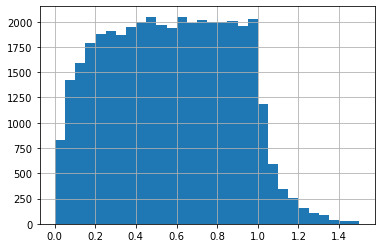

In [848]:
data.ranking_standard.hist(bins = 30)

In [849]:
data[['ranking_standard','Rating']].corr()

,ranking_standard,Rating
ranking_standard,1.000000,-0.485843
Rating,-0.485843,1.000000


### Создание столбца ranking_categories
Разделим непрерывную последовательность рейтингов ресторанов на категории для заполнения пропусков в других столбцах в разрезе этого признака.

In [850]:
bins_ranking = 100 # Настраиваемый параметр.

In [851]:
def ranking_categorization(x):
    """Функция разбивает последовательность рейтингов
    на заданное число категорий"""
    one_category = data.ranking_norm.max() / bins_ranking
    # Размер одной категории.
    return round(x / one_category, 0)

In [852]:
data['ranking_categories'] = data['ranking_norm'].apply(ranking_categorization)

In [853]:
data[['Rating','ranking_norm', 'ranking_categories']].corr()

,Rating,ranking_norm,ranking_categories
Rating,1.000000,-0.544589,-0.544628
ranking_norm,-0.544589,1.000000,0.999949
ranking_categories,-0.544628,0.999949,1.000000


### Продолжаем заполнять price_range
Окончательное заполнение пропусков в столбце с ценовой категорией проведем на основе вновь созданного столбца ranking_absolut.

<AxesSubplot:>

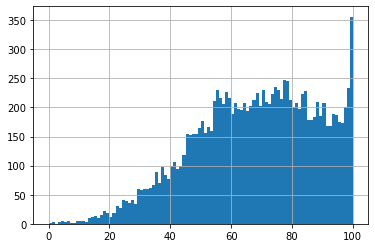

In [854]:
data[pd.isnull(data.price_range)].ranking_categories.hist(bins=100)
# Больше всего незаполненных прайсов у ресторанов стоящих в рейтинге ниже среднего.

<AxesSubplot:>

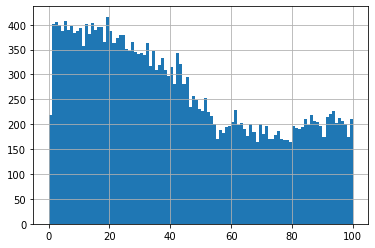

In [855]:
data[pd.notnull(data.price_range)].ranking_categories.hist(bins=100)
# У ресторанов с заполненным прайсом картина противоположная.

In [856]:
def price_completion(row):
    if pd.isnull(row['price_range']):
        if row['ranking_categories'] > bins_ranking / 2:
            return 1.0
        else:
            return 2.0 
    else:
        return row['price_range']

In [857]:
data['price_range'] = data.apply(price_completion, axis = 1)

In [858]:
data['price_range'].isnull().sum()

0

<AxesSubplot:>

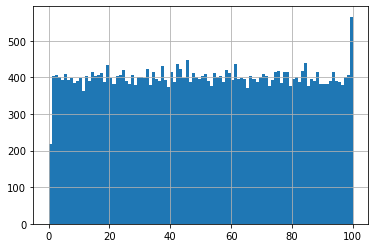

In [859]:
data[pd.notnull(data.price_range)].ranking_categories.hist(bins=100)
# После заполнения пропусков картина выровнялась.

In [860]:
data[['Rating','ranking','ranking_categories','price_range']].corr()
# Корреляция price_range с целевой переменной многократно увеличилась.

,Rating,ranking,ranking_categories,price_range
Rating,1.000000,-0.368371,-0.544628,0.120475
ranking,-0.368371,1.000000,0.572254,-0.240847
ranking_categories,-0.544628,0.572254,1.000000,-0.459464
price_range,0.120475,-0.240847,-0.459464,1.000000


### Создание столбца age_ta (продолжительность существования ресторана на TripAdvisor)
Для определения того, как долго существует ресторан, будем ориентироваться на идентификационный номер ресторана на сайте ТА. Очевидно, что эти номера присваивают по мере регистрации ресторана на сайте, а это значит, что чем больше id_ta, тем моложе ресторан. Минимальный и максимальный номера определят срез ресторанов, который попал в датасет.

Вторым источником информации будут даты самого первого и самого последнего отзыва в датасете. По этим датам мы определим временной период, за который были взяты данные. Понятно, что дата регистрации и дата первого отзыва могут немного отличаться, но этой погрешностью мы пренебрежем.


In [861]:
display(data['date_1'].min(),
        data['date_1'].max(),
        data['date_2'].min(),
        data['date_2'].max())

Timestamp('2007-11-14 00:00:00')

Timestamp('2018-02-26 00:00:00')

Timestamp('2004-04-21 00:00:00')

Timestamp('2018-02-26 00:00:00')

Последние даты и первого и второго отзыва совпадают (2018-02-26), очевидно это и есть дата взятия данных с сайта для данного датасета. Самый ранний отзыв в датасете - 2004-04-21, примем эту дату за начало отсчета.

Расчитаем временной период, за который были взяты данные.

In [862]:
time_period = data['date_2'].max() - data['date_2'].min()
time_period

Timedelta('5059 days 00:00:00')

Посмотрим, сколько ресторанов было зарегестрировано на ТА за это время.

In [863]:
quantity_rest = data.id_ta.max() - data.id_ta.min()
display(quantity_rest, data.id_ta.min(), data.id_ta.max())

12827031

680315

13507346

На TripAdvisor было зарегистрировано за это время более 13.5 миллионов ресторанов, а в нашем датасете 40000.

Проверим, сколько ресторанов в день регистрировалось в среднем на ТА.

In [864]:
daily_quantity = round(quantity_rest / 5059, 0)
daily_quantity

2535.0

Создадим функцию, которая будет разбивать последовательность номеров id_ta на интервалы номеров присваиваемых в течение одного дня (5059), и определять в какой интервал попадает переданный ей id из датасета. Таким образом эта функция будет определять сколько дней назад ресторан был зарегистрирован на сайте TripAdvisor.

In [865]:
def age_rest(x):
    days = 5060
    min_id = 680315
    max_id = 13507346
    for i in range(1, 5061):
        if (min_id <= x < min_id + i*2535):
            return days
        else:
            days = days - 1            

In [866]:
data['age_ta'] = data['id_ta'].apply(age_rest)

In [867]:
data[['Rating','age_ta','id_ta']].corr()

,Rating,age_ta,id_ta
Rating,1.000000,-0.159111,0.159111
age_ta,-0.159111,1.000000,-1.000000
id_ta,0.159111,-1.000000,1.000000


### Создание столбца age_ta_categories
Разобьем числовой столбец давности регистрации на ТА на категории и создадим новый столбец для 

In [868]:
bins_age = 25 # Настраиваемый параметр - количество градаций параметра 'age_ta_categories'.
# Такое значение было подобрано эмпирически по максимальной корреляции с целевой переменной.

In [869]:
def age_categorization(x):
    one_category = data.age_ta.max() / bins_age
    return round(x / one_category, 0)

In [870]:
data['age_ta_categories'] = data['age_ta'].apply(age_categorization)

In [871]:
data[['Rating','age_ta','id_ta','age_ta_categories']].corr()

,Rating,age_ta,id_ta,age_ta_categories
Rating,1.000000,-0.159111,0.159111,-0.158864
age_ta,-0.159111,1.000000,-1.000000,0.999295
id_ta,0.159111,-1.000000,1.000000,-0.999295
age_ta_categories,-0.158864,0.999295,-0.999295,1.000000


In [872]:
data[['number_of_reviews','Rating']].corr()

,number_of_reviews,Rating
number_of_reviews,1.000000,0.030964
Rating,0.030964,1.000000


### Создание столбца country
Вручную создадим словарь соответствия города своей стране.

In [873]:
city_country_dict  = {'Prague': 'Czech',
                     'Geneva': 'Switzerland',
                     'Oslo': 'Norway',
                     'Munich': 'Germany',
                     'London': 'Great Britain',
                     'Bratislava': 'Slovakia',
                     'Lyon': 'France',
                     'Krakow': 'Poland',
                     'Ljubljana': 'Slovenia',
                     'Zurich': 'Switzerland',
                     'Copenhagen': 'Denmark',
                     'Amsterdam': 'Netherlands',
                     'Oporto': 'Portugal',
                     'Brussels': 'Belgium',
                     'Budapest': 'Hungary',
                     'Rome': 'Italy',
                     'Warsaw': 'Poland',
                     'Paris': 'France',
                     'Vienna': 'Austria',
                     'Barcelona': 'Spain',
                     'Berlin': 'Germany',
                     'Luxembourg': 'Luxembourg',
                     'Edinburgh': 'Great Britain',
                     'Madrid': 'Spain',
                     'Helsinki': 'Finland',
                     'Athens': 'Greece',
                     'Stockholm': 'Sweden',
                     'Dublin': 'Great Britain',
                     'Hamburg': 'Germany',
                     'Milan': 'Italy',
                     'Lisbon': 'Portugal'}
                          

Создаем столбец на основе словаря.

In [874]:
data['country'] = data.apply(lambda x: city_country_dict[x['city']], axis = 1)

<AxesSubplot:xlabel='country'>

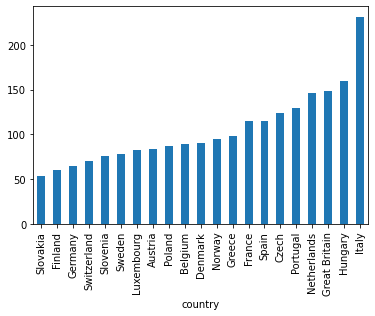

In [875]:
data.groupby('country').number_of_reviews.mean().sort_values().plot(kind = 'bar')

<AxesSubplot:xlabel='city'>

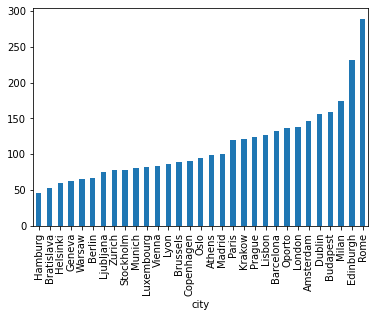

In [876]:
data.groupby('city').number_of_reviews.mean().sort_values().plot(kind = 'bar')

### Заполнение пропусков в столбце number_of_reviews
 

Перед заполнением сохраним в новом столбце информацию о том, где были пропуски.

In [877]:
data['number_of_reviews_isnan'] = pd.isna(data['number_of_reviews']).astype('uint8')

<AxesSubplot:>

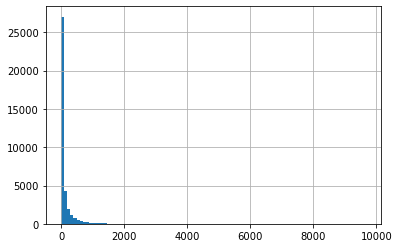

In [878]:
data.number_of_reviews.hist(bins = 100)

В этом столбце значения распределены не равномерно, имеется длинный хвост, причем начиная с 2000 отзывов каждое значение встречается лишь единожды и очень далеко отстоит от предыдущего значения. 

In [879]:
data[['number_of_reviews','Rating']].corr()

,number_of_reviews,Rating
number_of_reviews,1.000000,0.030964
Rating,0.030964,1.000000


Удалим экстремальные значения. Позднее заполним эти пропуски вместе с остальными.

In [880]:
data['number_of_reviews'] = data['number_of_reviews'].apply(lambda x: np.nan if x > 4700 else x)

In [881]:
data[['number_of_reviews','Rating']].corr()

,number_of_reviews,Rating
number_of_reviews,1.000000,0.034177
Rating,0.034177,1.000000


Начнем заполнять пропуски в разрезе трех категориальных столбцов: country, ranking_categories, age_ta_categories. От этих признаков количество отзывов зависит больше всего.

<AxesSubplot:xlabel='country'>

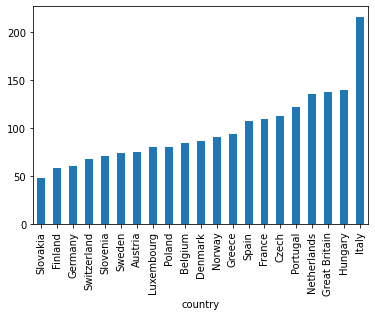

In [893]:
data.groupby('country').number_of_reviews.mean().sort_values().plot(kind = 'bar')

<AxesSubplot:xlabel='ranking_categories'>

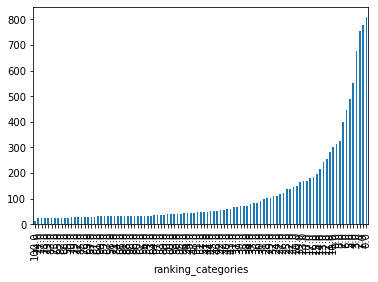

In [894]:
data.groupby('ranking_categories').number_of_reviews.mean().sort_values().plot(kind = 'bar')

<AxesSubplot:xlabel='age_ta_categories'>

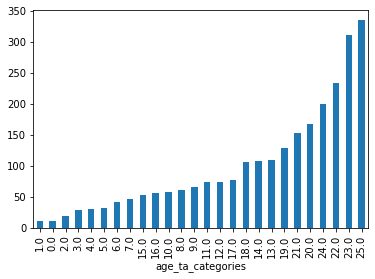

In [895]:
data.groupby('age_ta_categories').number_of_reviews.mean().sort_values().plot(kind = 'bar')

In [882]:
data.number_of_reviews.fillna(round(data.groupby(['country','ranking_categories','age_ta_categories'])
                                    .number_of_reviews.transform('mean'),0), inplace=True)

In [883]:
data[['Rating','number_of_reviews']].corr()

,Rating,number_of_reviews
Rating,1.00000,0.03077
number_of_reviews,0.03077,1.00000


In [884]:
data.number_of_reviews.isnull().sum()

1159

In [885]:
data.number_of_reviews.fillna(round(data.groupby(['ranking_categories','age_ta_categories'])
                                    .number_of_reviews.transform('mean'),0), inplace=True)

In [886]:
data.number_of_reviews.isnull().sum()

36

In [887]:
data[['Rating','number_of_reviews']].corr()

,Rating,number_of_reviews
Rating,1.000000,0.030163
number_of_reviews,0.030163,1.000000


In [888]:
data.number_of_reviews.fillna(round(data.groupby(['ranking_categories'])
                                    .number_of_reviews.transform('mean'),0), inplace=True)

In [889]:
data.number_of_reviews.isnull().sum()

0

In [890]:
data[['Rating','number_of_reviews']].corr()

,Rating,number_of_reviews
Rating,1.000000,0.030339
number_of_reviews,0.030339,1.000000


### Создание признака reviews_month (количество отзывов в месяц)
Можно сказать, что это частота озывов.

In [896]:
data['reviews_month'] = round(data['number_of_reviews'] / (data['age_ta'] / 30),1)

### Создание признаков fresh_review_1 (давность предпоследнего отзыва),  fresh_review_1 (давность последнего отзыва) и between_reviews (время между отзывами)
Для это из даты взятия данных для датасета 2018-02-26 вычитаем дату отзывов и из даты последнего отзыва вычитаем дату предпоследнего.

In [897]:
data['fresh_review_1'] = data['date_1'].max() - data['date_1']
data['fresh_review_2'] = data['date_2'].max() - data['date_2']
data['between_reviews'] = data['date_2'] - data['date_1']

Для расчетов переведем тип timedelta во float.

In [898]:
data['fresh_review_1'] = data['fresh_review_1'].dt.days
data['fresh_review_2'] = data['fresh_review_2'].dt.days
data['between_reviews'] = data['between_reviews'].dt.days

### Заполнение пропусков в столбцах fresh_review_1, fresh_review_2 и between_reviews
Так как в некоторых отзывах-строках еще до их преобразования содержались только кавычки и скобки, то после их раскрытия появились пустые отзывы без дат.

Заполним эти пропуски в разрезе столбца ranking_stars.

In [899]:
data.fresh_review_1.fillna(round(data.groupby(['ranking_categories'])
                                 .fresh_review_1.transform('median'),0), inplace=True)

data.fresh_review_2.fillna(round(data.groupby(['ranking_categories'])
                                 .fresh_review_2.transform('median'),0), inplace=True)

data.between_reviews.fillna(round(data.groupby(['ranking_categories'])
                                  .between_reviews.transform('median'),0), inplace=True)

### Создание столбца michelin_population, rest_population, michelin_rest
На основе данных из  Guide о количестве рекомендованных для посещения ресторанов в каждом из городов датасета и данных о численности населения этих городов, а также о количестве ресторанов в датасете вручную составим словарь. 

In [900]:
michelin_rest_populat = {'Paris': [426, 2148327, 13986.0],
                         'Stockholm': [40, 1006984, 2464.0],
                         'London': [390, 8908081, 16444.0],
                         'Berlin': [64, 3644826, 6372.0],
                         'Munich': [56, 1471508, 2763.0],
                         'Oporto': [21, 287591, 1484.0],
                         'Milan': [82, 1366180, 6275.0],
                         'Bratislava': [0, 437725, 889.0],
                         'Vienna': [54, 1911191, 3444.0],
                         'Rome': [53, 2870500, 5946.0],
                         'Barcelona': [63, 1664182, 7796.0],
                         'Madrid': [97, 3334730, 8809.0],
                         'Dublin': [43, 1173179, 1960.0],
                         'Brussels': [36, 185103, 3004.0],
                         'Zurich': [62, 434008, 1590.0],
                         'Warsaw': [15, 1790658,  2141.0],
                         'Budapest': [23, 1752286, 2438.0],
                         'Copenhagen': [61, 794128, 1964.0],
                         'Amsterdam': [68, 860124, 3249.0],
                         'Lyon': [81, 2233221, 2666.0],
                         'Hamburg': [52, 1845229, 2736.0],
                         'Lisbon': [35, 506654, 3717.0],
                         'Prague': [24, 1335084, 4188.0],
                         'Oslo': [32, 693494, 1137.0],
                         'Helsinki': [26, 656611, 1141.0],
                         'Edinburgh': [22, 488050, 1766.0],
                         'Geneva': [50, 201818, 1413.0],
                         'Ljubljana': [17, 286745, 468.0],
                         'Athens': [19, 664046, 1787.0],
                         'Luxembourg': [56, 633622, 621.0],
                         'Krakow': [1, 779115, 1244.0]}

In [901]:
data['michelin_population'] = data.apply(lambda x: michelin_rest_populat[x['city']][0]
                                         / michelin_rest_populat[x['city']][1], axis = 1)
# Количество мишленовских ресторанов на население города.

In [902]:
data['rest_population'] = data.apply(lambda x: michelin_rest_populat[x['city']][2]
                                         / michelin_rest_populat[x['city']][1], axis = 1)
# Общее количество ресторанов на население города.

In [903]:
data['michelin_rest'] = data.apply(lambda x: michelin_rest_populat[x['city']][0]
                                         / michelin_rest_populat[x['city']][2], axis = 1)
# Отношение мишленовских ресторанов к общему количеству ресторанов.

In [906]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Restaurant_id            40000 non-null  object        
 1   city                     40000 non-null  object        
 2   cuisine_style            40000 non-null  object        
 3   ranking                  40000 non-null  float64       
 4   Rating                   40000 non-null  float64       
 5   price_range              40000 non-null  float64       
 6   number_of_reviews        40000 non-null  float64       
 7   reviews                  40000 non-null  object        
 8   url_ta                   40000 non-null  object        
 9   id_ta                    40000 non-null  int64         
 10  review_2                 40000 non-null  object        
 11  date_2                   33529 non-null  datetime64[ns]
 12  review_1                 40000 n

### Перевод столбца city в числовой тип (Dummy-переменную)
Столбец city - это категориальная номинативная переменная имеющая тип object. Нейросеть не понимает строковые данные, ей нужны только цифры. Создадим на основе столбца city dummy-переменную, то есть отдельный столбец для каждого города, в котором будет значение 1, если название столбца совпадает со значением в столбце city, а в остальных случаях - 0.

In [908]:
data = pd.get_dummies(data, columns = ['city'], dummy_na = True)

KeyError: "None of [Index(['city'], dtype='object')] are in the [columns]"

### Перевод столбца country в числовой тип (Dummy-переменную)

In [909]:
data = pd.get_dummies(data, columns = ['country'], dummy_na = True)

### Перевод столбца cuisine в числовой вид (создание Dummy-переменной)

In [910]:
for cuisine in cuisine_list_improv:
    data[cuisine] = data['cuisine_style'].apply(lambda x: 1 if cuisine in x else 0)

### Удаление не нужных столбцов

In [911]:
data1 = data.copy()

In [912]:
data1.drop(['Restaurant_id','url_ta','reviews','review_2','review_1', 'date_2', 'date_1',
       'cuisine_style','name_rest'], axis = 1, inplace = True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [913]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = data1.drop(['Rating'], axis = 1)
y = data1['Rating']

In [914]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [915]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [916]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [917]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [918]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20106149999999998
